<a href="https://colab.research.google.com/github/ChrisWbe/CursoML/blob/main/ElandDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install eland

     |████████████████████████████████| 122kB 8.7MB/s 
     |████████████████████████████████| 327kB 8.5MB/s 


In [ ]:
#Conexion a Elasticsearch
#Se accede a una instancia elastic de prueba
ID = "eland-demo:dXMtY2VudHJhbDEuZ2NwLmNsb3VkLmVzLmlvJDI2ODUwMzAzNWRjYTQ5ZDdiM2NmNzdlYzNmNTVhZmI5JDdlYTZiY2UyZWVmZjQ1MTk5YzdiMzNlNDEzZTZhN2Q0"
PASS = "kDf3NZUfvmlq46TyNgrfaxvC"

In [ ]:
import eland as ed
import pandas as pd
import numpy as np
from elasticsearch import Elasticsearch

In [ ]:
#Funcion para imprimir un JSON muy largo
def json(x):
  import json
  print(json.dumps(x,indent=2,sort_keys=True))

In [ ]:
#Conexion a la instancia de elastic cloud
es = Elasticsearch(
    cloud_id=ID,
    http_auth=('elastic',PASS)
)
json(es.info())

{
  "cluster_name": "268503035dca49d7b3cf77ec3f55afb9",
  "cluster_uuid": "gW23ez7WS8eLXVd6QbFVPA",
  "name": "instance-0000000000",
  "tagline": "You Know, for Search",
  "version": {
    "build_date": "2020-12-05T01:00:33.671820Z",
    "build_flavor": "default",
    "build_hash": "1c34507e66d7db1211f66f3513706fdf548736aa",
    "build_snapshot": false,
    "build_type": "docker",
    "lucene_version": "8.7.0",
    "minimum_index_compatibility_version": "6.0.0-beta1",
    "minimum_wire_compatibility_version": "6.8.0",
    "number": "7.10.1"
  }
}


Se realiza conexión a una instancia de Elastic con versión 7.10.1

In [ ]:
#Cargo datos a un dataframe de pandas
pd_df = pd.read_csv("/content/sample_data/california_housing_test.csv")
pd_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085,344700.0
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990,176500.0
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934,270500.0
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359,330000.0
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375,81700.0


In [ ]:
before_rows = pd_df.shape[0]
pd_df = pd_df.dropna()
after_rows = pd_df.shape[0]
print("Filas eliminadas -> ",(before_rows-after_rows))

Filas eliminadas ->  0


In [ ]:
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           3000 non-null   float64
 1   latitude            3000 non-null   float64
 2   housing_median_age  3000 non-null   float64
 3   total_rooms         3000 non-null   float64
 4   total_bedrooms      3000 non-null   float64
 5   population          3000 non-null   float64
 6   households          3000 non-null   float64
 7   median_income       3000 non-null   float64
 8   median_house_value  3000 non-null   float64
dtypes: float64(9)
memory usage: 234.4 KB


<h2 style="color:purple">Data Cleaning</h2>

In [ ]:
pd_df['location'] = pd_df[['latitude','longitude']].apply(lambda x:",".join(str(item) for item in x), axis=1) #Se combinan latitud y lonitud y se agregan a una nueva columna
pd_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,location
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085,344700.0,"37.37,-122.05"
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990,176500.0,"34.26,-118.3"
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934,270500.0,"33.78,-117.81"
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359,330000.0,"33.82,-118.36"
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375,81700.0,"36.33,-119.67"


In [ ]:
pd_df.drop(['longitude','latitude'],axis=1, inplace=True) #Se eliminan las columnas de latitud y longitud
pd_df.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,location
0,27.0,3885.0,661.0,1537.0,606.0,6.6085,344700.0,"37.37,-122.05"
1,43.0,1510.0,310.0,809.0,277.0,3.5990,176500.0,"34.26,-118.3"
2,27.0,3589.0,507.0,1484.0,495.0,5.7934,270500.0,"33.78,-117.81"
3,28.0,67.0,15.0,49.0,11.0,6.1359,330000.0,"33.82,-118.36"
4,19.0,1241.0,244.0,850.0,237.0,2.9375,81700.0,"36.33,-119.67"


In [ ]:
df = ed.pandas_to_eland(
    pd_df=pd_df,
    es_client=es,

    #Nombre del indice para ElasticSearch
    es_dest_index="california_housing_test",

    #Algunos tipos de columnas en nuestro dataset, location se detecta automáticamente como 'keyword', para este caso se interpretará como 'geo_point'
    #El resto de columnas se puede dejar tal cual ya que son valores enteros/flotantes
    es_type_overrides={
        "location":"geo_point",
    },

    #Si el index existe se reemplazara
    es_if_exists="replace",

    #Esperar a que los datos se indexen antes de regresar
    es_refresh=True,
)
df.info()

<class 'eland.dataframe.DataFrame'>
Index: 3000 entries, 575 to 2499
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   households          3000 non-null   float64
 1   housing_median_age  3000 non-null   float64
 2   location            3000 non-null   object 
 3   median_house_value  3000 non-null   float64
 4   median_income       3000 non-null   float64
 5   population          3000 non-null   float64
 6   total_bedrooms      3000 non-null   float64
 7   total_rooms         3000 non-null   float64
dtypes: float64(7), object(1)
memory usage: 80.000 bytes
Elasticsearch storage usage: 1.073 MB


<p>Despues de crear el index-pattern se observa en kibana los datos almacenados en ElasticSearch</p>

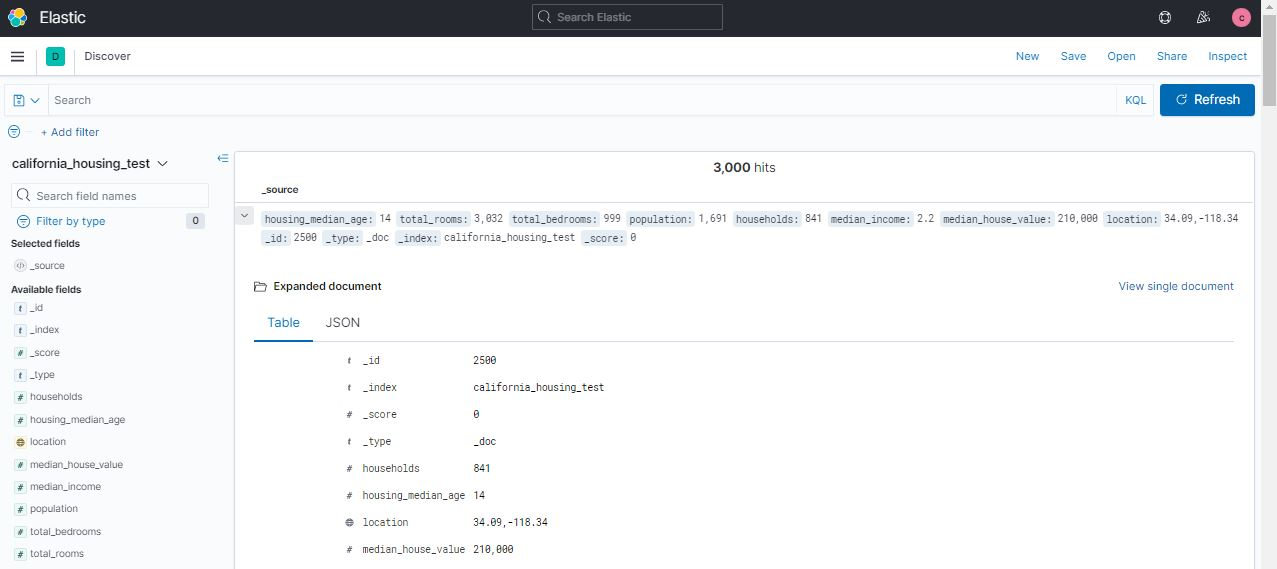

In [ ]:
json(es.indices.get_mapping(index="california_housing_test"))

{
  "california_housing_test": {
    "mappings": {
      "properties": {
        "households": {
          "type": "double"
        },
        "housing_median_age": {
          "type": "double"
        },
        "location": {
          "type": "geo_point"
        },
        "median_house_value": {
          "type": "double"
        },
        "median_income": {
          "type": "double"
        },
        "population": {
          "type": "double"
        },
        "total_bedrooms": {
          "type": "double"
        },
        "total_rooms": {
          "type": "double"
        }
      }
    }
  }
}


In [ ]:
df.shape #Arroja información de dataframe, en este caso 3000 filas y 8 columnas

(3000, 8)

In [ ]:
#compatible con la forma en la que trabaja pandas
df[(df['housing_median_age'] <= 20.0) & (df['population']<=1000)]

,households,housing_median_age,location,median_house_value,median_income,population,total_bedrooms,total_rooms
2506,332.0,15.0,"32.92,-117.14",174400.0,5.2864,949.0,314.0,1558.0
2512,123.0,17.0,"38.33,-122.32",209300.0,5.0877,370.0,118.0,851.0
2528,219.0,4.0,"33.68,-117.82",360600.0,8.7974,603.0,213.0,1346.0
2558,346.0,18.0,"39.8,-123.47",79200.0,2.3571,863.0,545.0,2130.0
2567,262.0,16.0,"35.33,-120.9",266300.0,3.5880,595.0,287.0,1576.0
...,...,...,...,...,...,...,...,...
2469,185.0,16.0,"33.84,-116.51",100000.0,4.0729,454.0,193.0,980.0
2472,90.0,16.0,"38.05,-121.34",244700.0,5.6147,267.0,92.0,667.0
2473,350.0,16.0,"33.84,-117.87",139000.0,4.5112,730.0,354.0,1545.0
2484,107.0,7.0,"33.77,-118.02",181300.0,5.2077,232.0,118.0,586.0


In [ ]:
df['population'].mean()

1402.7986666666666

In [ ]:
df.total_rooms

2500    3032.0
2501    5210.0
2502      49.0
2503    2342.0
2504     967.0
         ...  
2495    2064.0
2496    4513.0
2497    2016.0
2498    1763.0
2499    2131.0
Name: total_rooms, Length: 3000, dtype: float64

In [ ]:
print(df[df['population'] > 1000].es_info()) #Información del dataframe y los datos almacenados en ElasticSearch

es_index_pattern: california_housing_test
Index:
 es_index_field: _id
 is_source_field: False
Mappings:
 capabilities:
                         es_field_name  is_source   es_dtype es_date_format pd_dtype  is_searchable  is_aggregatable  is_scripted aggregatable_es_field_name
households                  households       True     double           None  float64           True             True        False                 households
housing_median_age  housing_median_age       True     double           None  float64           True             True        False         housing_median_age
location                      location       True  geo_point           None   object           True             True        False                   location
median_house_value  median_house_value       True     double           None  float64           True             True        False         median_house_value
median_income            median_income       True     double           None  float64           T

En "tasks" se puede ver el filtro empleado para obtener dicho resultado

In [ ]:
#Agregaciones
df[['housing_median_age']].agg(['median','mean','max','min','var'])

,housing_median_age
median,29.000000
mean,28.845333
max,52.000000
min,1.000000
var,157.611682


In [ ]:
df[['housing_median_age']].describe()

,housing_median_age
count,3000.000000
mean,28.845333
std,12.553303
min,1.000000
25%,18.166667
50%,29.000000
75%,37.000000
max,52.000000


In [ ]:
df[['population']].describe()

,population
count,3000.000000
mean,1402.798667
std,1030.371241
min,5.000000
25%,779.683083
50%,1156.901104
75%,1743.261364
max,11935.000000


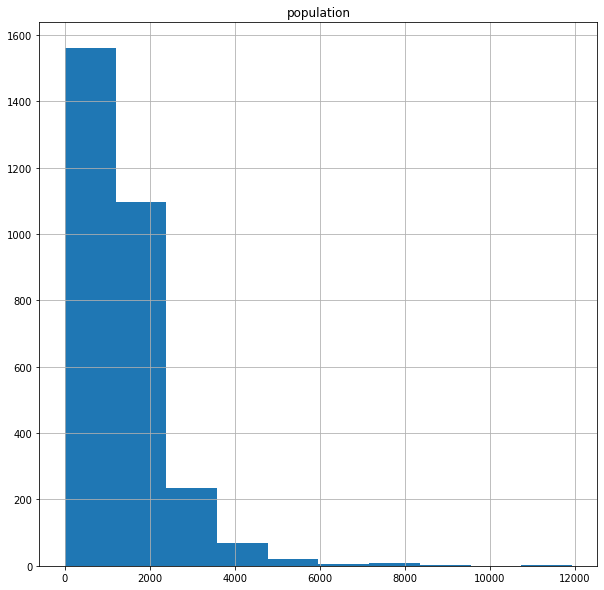

In [ ]:
#Dibujando histograma
from matplotlib import pyplot as plt

df[['population']].hist(figsize=(10,10))
plt.show()

In [ ]:
#De igual forma se puede agregar query directamente para realizar busquedas en ElasticSearch
df.es_query({
    "match":{
        "housing_median_age":15.0
    }
})

,households,housing_median_age,location,median_house_value,median_income,population,total_bedrooms,total_rooms
2506,332.0,15.0,"32.92,-117.14",174400.0,5.2864,949.0,314.0,1558.0
2534,434.0,15.0,"37.66,-120.96",145200.0,3.8542,1296.0,434.0,2485.0
2575,445.0,15.0,"41.28,-122.45",128800.0,3.4519,1188.0,503.0,2740.0
2579,1300.0,15.0,"38.77,-121.14",287800.0,6.4789,3868.0,1333.0,10282.0
2587,246.0,15.0,"36.82,-119.72",52500.0,2.2639,550.0,239.0,946.0
...,...,...,...,...,...,...,...,...
2399,498.0,15.0,"33.9,-117.95",372600.0,6.8429,1679.0,479.0,3057.0
2408,641.0,15.0,"32.72,-116.98",158300.0,4.5135,1914.0,680.0,4209.0
2459,347.0,15.0,"36.85,-119.64",157300.0,4.9904,1258.0,353.0,2397.0
2483,774.0,15.0,"37.51,-122.47",364300.0,6.7606,2222.0,764.0,4974.0


In [ ]:
print(type(df))

<class 'eland.dataframe.DataFrame'>


In [ ]:
sample_df = df[df.housing_median_age == 15.0].sample(10).to_pandas()
sample_df.info()
print(type(sample_df))

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 1326 to 862
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   households          10 non-null     float64
 1   housing_median_age  10 non-null     float64
 2   location            10 non-null     object 
 3   median_house_value  10 non-null     float64
 4   median_income       10 non-null     float64
 5   population          10 non-null     float64
 6   total_bedrooms      10 non-null     float64
 7   total_rooms         10 non-null     float64
dtypes: float64(7), object(1)
memory usage: 720.0+ bytes
<class 'pandas.core.frame.DataFrame'>


Se observa el cambio entre el DataFrame de Eland y el DataFrame de Pandas

In [ ]:
sample_df

,households,housing_median_age,location,median_house_value,median_income,population,total_bedrooms,total_rooms
1326,475.0,15.0,"38.66,-121.27",189800.0,4.1382,1032.0,520.0,2642.0
1441,1906.0,15.0,"39.76,-121.89",142600.0,3.0700,4591.0,1860.0,10265.0
1682,1415.0,15.0,"33.87,-117.6",138100.0,3.4419,3823.0,1570.0,7626.0
1972,267.0,15.0,"34.24,-116.87",182800.0,3.9688,622.0,822.0,4419.0
2490,526.0,15.0,"33.89,-117.97",367400.0,9.0683,1992.0,542.0,3801.0
2506,332.0,15.0,"32.92,-117.14",174400.0,5.2864,949.0,314.0,1558.0
2635,407.0,15.0,"39.15,-121.64",124900.0,5.2340,1159.0,396.0,2659.0
426,1118.0,15.0,"33.13,-117.03",172800.0,4.7022,3555.0,1185.0,7000.0
730,505.0,15.0,"36.82,-119.69",93600.0,4.8100,1687.0,512.0,3303.0
862,513.0,15.0,"35.65,-117.68",81900.0,3.3269,1245.0,576.0,2701.0


<h1>ML Demo</h1>

In [ ]:
#Se utiliza la librería de ML ScikitLearn, en este caso se realizará una clasificacion de arbol
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier

#Entrenando datos localmente
digits = datasets.load_wine()
print("Nombre de caracteristicas o Features: ",digits.feature_names)
print("Datos de ejmeplo: ", digits.data[0])

#se guardan los datos 10, 80 y 140 para testing en el modelo
data = [x for i, x in enumerate(digits.data) if i not in (10,80,140)]
target = [x for i, x in enumerate(digits.target) if i not in (10,80,140)]

#Ajuste del modelo
sk_classifier = DecisionTreeClassifier()
sk_classifier.fit(data, target) #Acá sucede todo el proceso

print(sk_classifier.predict(digits.data[[10,80,140]])," Predicciones para las entradas dadas")
print(digits.target[[10,80,140]], " Valores reales")

Nombre de caracteristicas o Features:  ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Datos de ejmeplo:  [1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00 3.060e+00
 2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03]
[0 1 2]  Predicciones para las entradas dadas
[0 1 2]  Valores reales


Se realizó una buena clasificación

In [52]:
digits

{'DESCR': '.. _wine_dataset:\n\nWine recognition dataset\n------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 178 (50 in each of three classes)\n    :Number of Attributes: 13 numeric, predictive attributes and the class\n    :Attribute Information:\n \t\t- Alcohol\n \t\t- Malic acid\n \t\t- Ash\n\t\t- Alcalinity of ash  \n \t\t- Magnesium\n\t\t- Total phenols\n \t\t- Flavanoids\n \t\t- Nonflavanoid phenols\n \t\t- Proanthocyanins\n\t\t- Color intensity\n \t\t- Hue\n \t\t- OD280/OD315 of diluted wines\n \t\t- Proline\n\n    - class:\n            - class_0\n            - class_1\n            - class_2\n\t\t\n    :Summary Statistics:\n    \n    ============================= ==== ===== ======= =====\n                                   Min   Max   Mean     SD\n    ============================= ==== ===== ======= =====\n    Alcohol:                      11.0  14.8    13.0   0.8\n    Malic Acid:                   0.74  5.80    2.34  1.12\n    Ash:           

In [60]:
df_digits = pd.DataFrame(data=digits.data, columns=digits.feature_names)
df_digits['group'] = digits.target
df_digits

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,group
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [61]:
df_digits.iloc[[10,80,140]]

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,group
10,14.10,2.16,2.3,18.0,105.0,2.95,3.32,0.22,2.38,5.75,1.25,3.17,1510.0,0
80,12.00,0.92,2.0,19.0,86.0,2.42,2.26,0.30,1.43,2.50,1.38,3.12,278.0,1
140,12.93,2.81,2.7,21.0,96.0,1.54,0.50,0.53,0.75,4.60,0.77,2.31,600.0,2


In [67]:
#Como ya se tiene almacenado el modelo, ahora se pretende importar ese modelo a elasticsearch 
from eland.ml import ImportedMLModel

#Serializar el modelo hecho en ScikitLearn a ElasticSearch
ed_classifier = ImportedMLModel(
    es_client=es,
    model_id="classificador-vinos",
    model=sk_classifier, #Modelo realizado en ScikitLearn
    feature_names=digits.feature_names,
    es_if_exists="replace" #Sobreescribir si el modelo ya existe
)

#Se cambia overwrite por es_if_exists -> https://eland.readthedocs.io/en/latest/reference/api/eland.ml.MLModel.import_model.html

#Captura el llamado a ElasticSearch, se verifica que el modelo no está simplemente ejecutandose en local
import logging
logger = logging.getLogger('elasticsearch')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

#Se usan los mismos datos de antes, pero ahora con el modelo en elasticsearch
print(ed_classifier.predict(digits.data[[10,80,140]].tolist()))
print(digits.target[[10,80,140]])

logger.handlers = []

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: import_model is deprecated, use MLModel.import_model() instead
  # Remove the CWD from sys.path while we load stuff.
GET https://268503035dca49d7b3cf77ec3f55afb9.us-central1.gcp.cloud.es.io/_ml/trained_models/classificador-vinos [status:200 request:0.066s]
> None
< {"count":1,"trained_model_configs":[{"model_id":"classificador-vinos","created_by":"api_user","version":"7.10.1","create_time":1610668188564,"estimated_heap_memory_usage_bytes":2960,"estimated_operations":17,"license_level":"platinum","tags":[],"input":{"field_names":["alcohol","malic_acid","ash","alcalinity_of_ash","magnesium","total_phenols","flavanoids","nonflavanoid_phenols","proanthocyanins","color_intensity","hue","od280/od315_of_diluted_wines","proline"]},"inference_config":{"classification":{"num_top_classes":0,"top_classes_results_field":"top_classes","results_field":"predicted_value","num_top_feature_importance_values":0,"predictio

[0 1 2]
[0 1 2]


In [68]:
json( {"docs":[{"doc":{"_index":"_index","_type":"_doc","_id":"_id","_source":{"alcohol":14.1,"alcalinity_of_ash":18.0,"proanthocyanins":2.38,"od280/od315_of_diluted_wines":3.17,"total_phenols":2.95,"magnesium":105.0,"flavanoids":3.32,"proline":1510.0,"malic_acid":2.16,"ash":2.3,"nonflavanoid_phenols":0.22,"hue":1.25,"color_intensity":5.75,"ml":{"inference":{"prediction_score":1.0,"model_id":"classificador-vinos","prediction_probability":1.0,"predicted_value":"0"}}},"_ingest":{"timestamp":"2021-01-14T23:49:48.810226665Z"}}},{"doc":{"_index":"_index","_type":"_doc","_id":"_id","_source":{"alcohol":12.0,"alcalinity_of_ash":19.0,"proanthocyanins":1.43,"od280/od315_of_diluted_wines":3.12,"total_phenols":2.42,"magnesium":86.0,"flavanoids":2.26,"proline":278.0,"malic_acid":0.92,"ash":2.0,"nonflavanoid_phenols":0.3,"hue":1.38,"color_intensity":2.5,"ml":{"inference":{"prediction_score":1.0,"model_id":"classificador-vinos","prediction_probability":1.0,"predicted_value":"1"}}},"_ingest":{"timestamp":"2021-01-14T23:49:48.810255325Z"}}},{"doc":{"_index":"_index","_type":"_doc","_id":"_id","_source":{"alcohol":12.93,"alcalinity_of_ash":21.0,"proanthocyanins":0.75,"od280/od315_of_diluted_wines":2.31,"total_phenols":1.54,"magnesium":96.0,"flavanoids":0.5,"proline":600.0,"malic_acid":2.81,"ash":2.7,"nonflavanoid_phenols":0.53,"hue":0.77,"color_intensity":4.6,"ml":{"inference":{"prediction_score":1.0,"model_id":"classificador-vinos","prediction_probability":1.0,"predicted_value":"2"}}},"_ingest":{"timestamp":"2021-01-14T23:49:48.810286999Z"}}}]}
)

{
  "docs": [
    {
      "doc": {
        "_id": "_id",
        "_index": "_index",
        "_ingest": {
          "timestamp": "2021-01-14T23:49:48.810226665Z"
        },
        "_source": {
          "alcalinity_of_ash": 18.0,
          "alcohol": 14.1,
          "ash": 2.3,
          "color_intensity": 5.75,
          "flavanoids": 3.32,
          "hue": 1.25,
          "magnesium": 105.0,
          "malic_acid": 2.16,
          "ml": {
            "inference": {
              "model_id": "classificador-vinos",
              "predicted_value": "0",
              "prediction_probability": 1.0,
              "prediction_score": 1.0
            }
          },
          "nonflavanoid_phenols": 0.22,
          "od280/od315_of_diluted_wines": 3.17,
          "proanthocyanins": 2.38,
          "proline": 1510.0,
          "total_phenols": 2.95
        },
        "_type": "_doc"
      }
    },
    {
      "doc": {
        "_id": "_id",
        "_index": "_index",
        "_ingest": {
    